# Enviorment Setup 

Importing required libraries


In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import IPython.display as display

import pathlib
import shutil
import tempfile
import datetime

AUTOTUNE = tf.data.experimental.AUTOTUNE

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn import preprocessing
from  IPython import display
from sklearn.metrics import roc_auc_score


In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Upziping the file to root directory

In [3]:
import zipfile
with zipfile.ZipFile("./drive/MyDrive/Images.zip", 'r') as zip_ref:
    zip_ref.extractall('./')

In [4]:
df_train= pd.read_csv("./drive/MyDrive/S40AR_train_data.csv")
df_train.head()

,FileName,action,action_class
0,Img_1000.jpg,walking_the_dog,Interacting_with_animal
1,Img_1001.jpg,riding_a_bike,other_activity
2,Img_1002.jpg,gardening,domestic_work
3,Img_1008.jpg,cooking,domestic_work
4,Img_1010.jpg,jumping,other_activity


## Function definations

In [5]:

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
# This callback will stop the training when there is no improvement in
# the loss for 10 consecutive epochs.

In [6]:
def plotter(model_name):
# summarize history for accuracy
      plt.plot(model_name.history['Action_Accuracy'])
      plt.plot(model_name.history['val_Action_Accuracy'])
      plt.title('model Action accuracy')
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.legend(['train', 'val'], loc='upper left')
      plt.show()
      # summarize history for loss
      plt.plot(model_name.history['Action_class_Accuracy'])
      plt.plot(model_name.history['val_Action_class_Accuracy'])
      plt.title('model Action_class accuracy')
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Exploratory Data Analysis

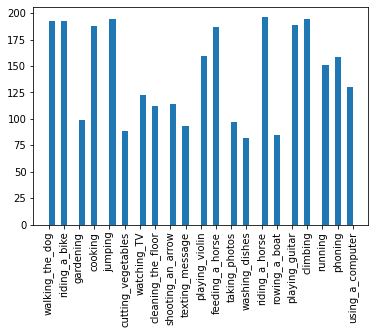

([0, 1, 2, 3, 4], <a list of 5 Text major ticklabel objects>)

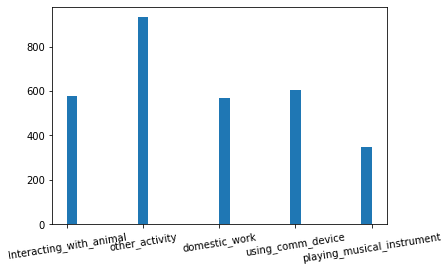

In [ ]:
#Checking the distribution of the class in train dataset, we can see classes imbalance and ideally will take f1 score(balance between precision & recall) into consideration.
#But we choose Accuracy as its a classification task and its very intuitive and even the classes are not that imbalanced.
plt.hist(df_train['action'],bins=50)
plt.xticks(rotation=90)
plt.show()

plt.hist(df_train['action_class'],bins=30)
plt.xticks(rotation=9)


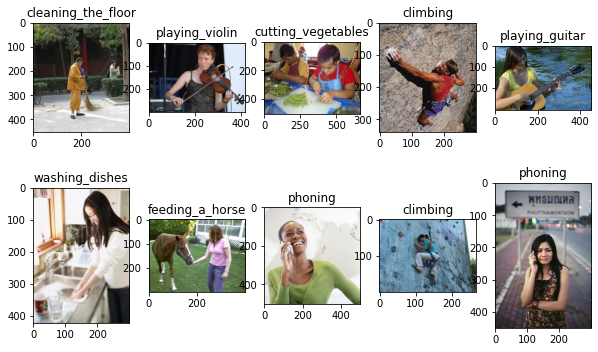

In [ ]:
#Checking the dataset images we can see they are of variable sizes and actions.
plt.figure(figsize=(10,6))
i=1
for index, row in df_train.sample(10).iterrows():
    image = np.asarray(Image.open('./drive/MyDrive/Images/'+ row.FileName))
    plt.subplot(2,5,i)
    plt.imshow(image)
    plt.title(row.action)
    i=i+1
plt.show()

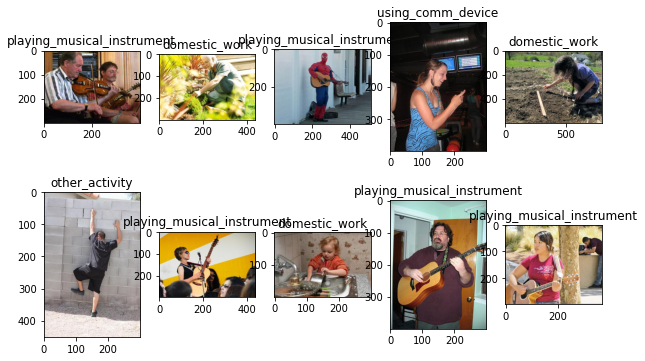

In [ ]:
#Checking the dataset images we can see they are of variable sizes and action_class.
plt.figure(figsize=(10,6))
i=1
for index, row in df_train.sample(10).iterrows():
    image = np.asarray(Image.open('./drive/MyDrive/Images/'+ row.FileName))
    plt.subplot(2,5,i)
    plt.imshow(image)
    plt.title(row.action_class)
    i=i+1
plt.show()

In [7]:
#Label encoding classes to change them to unique numerical values for further evaluation.

#Used/Initialised 2 encoders.
ActionEncoder = preprocessing.LabelEncoder()
ActionClassEncoder = preprocessing.LabelEncoder()
#Fitting the encoders
ActionEncoder.fit(df_train.action)
ActionClassEncoder.fit(df_train.action_class)
#Transforming the fitted encoders
df_train.action=ActionEncoder.transform(df_train.action)
df_train.action_class=ActionClassEncoder.transform(df_train.action_class)

df_train.head()

,FileName,action,action_class
0,Img_1000.jpg,18,0
1,Img_1001.jpg,10,2
2,Img_1002.jpg,5,1
3,Img_1008.jpg,2,1
4,Img_1010.jpg,6,2


In [8]:
#Splitting the df_train into train-validation-test data-frame implementing hold-out validation. (60-20-20)

train_data, test_data = train_test_split(df_train, test_size=0.2, random_state=40)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=40)
print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))


Train data : 1818, Val Data: 606, Test Data: 606


#Custom Data Generator

In [9]:
#Create the data generator for each split
import tensorflow.keras as keras
from scipy.interpolate import interp1d
import numpy as np
from scipy.ndimage.interpolation import rotate, shift

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_frame, batch_size=8, dim=(32, 32, 3), data_mean=0, data_std=255.0,  data_prefix='', shuffle=True, 
               Augment=True, with_labels = True):
        'Initialization'
        self.dim = dim  # Dimentions of the input
        self.withLabels = with_labels
        self.batch_size = batch_size
        self.n_classes_Action = 21  # Number of classes for action target class.
        self.n_classes_ActionClass = 5  # Number of classes for actionClass target class.
        self.shuffle = shuffle  
        self.Augment = Augment 

        # The data is input as a pandas dataframe, we need to read the relevent fields
        self.data_frame = data_frame
        self.image_Action_label = data_frame['action'].values.tolist() 
        self.image_ActionClass_label = data_frame['action_class'].values.tolist() 
        self.image_ids = np.arange(len(self.image_Action_label)).tolist() 
        self.data_prefix = data_prefix
        
        # Data normalization parameters
        self.data_mean = data_mean
        self.data_std = data_std
        
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data for the given index'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of IDs
        data_ids_temp = [self.image_ids[k] for k in indexes]
        image_Action_label_temp = [self.image_Action_label[k] for k in indexes]
        image_ActionClass_label_temp = [self.image_ActionClass_label[k] for k in indexes]
        # Generate data
        X, y_A, y_AC = self.__data_generation(data_ids_temp, image_Action_label_temp, image_ActionClass_label_temp)
        
        return X, {'Action':y_A,'Action_class':y_AC}

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            

    # Support function
    def __data_generation(self, data_ids_temp, image_Action_label_temp, image_ActionClass_label_temp):
        'Generates data containing batch_size samples' 

        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y_A = np.empty((self.batch_size), dtype=int)
        y_AC = np.empty((self.batch_size), dtype=int)
        
        # Generate data
        for i, ids in enumerate(data_ids_temp):
            
            X[i,] = self.__read_data_instance(data_ids_temp[i])
            y_A[i] = image_Action_label_temp[i]
            y_AC[i] = image_ActionClass_label_temp[i]
            
        return X, keras.utils.to_categorical(y_A, num_classes=self.n_classes_Action), keras.utils.to_categorical(y_AC, num_classes=self.n_classes_ActionClass)


    def __read_data_instance(self, pid):
      # Read an image
      filepath = self.data_prefix + self.data_frame.iloc[pid]['FileName']
      
      data = Image.open(filepath)
      data = data.resize((self.dim[0],self.dim[1]))
      data = np.asarray(data)

      if self.Augment:

        fliprl = np.random.rand(1) < 0.5 #flip the image left-right
        if fliprl:
          data = np.fliplr(data)
        rot = np.random.rand(1) < 0.5 #rotating the image
        if rot:
            rot = np.random.randint(-10,10, size=1)
            data = rotate(data, angle=rot[0], reshape=False)
        shifting = np.random.rand(1) <0.5 #shifting the image
        if shifting:
            shift_val = np.random.randint(-5, high=5, size=2, dtype=int).tolist() + [0,]
            data = shift(data, shift_val, order=0, mode='constant', cval=0.0, prefilter=False)

      X = data

      # Input normalization
      X = (X - self.data_mean)/self.data_std
      # print('X Shape: '+ str(X.shape))
      return X

####Setting Up Generators for Train, Test, Validate data splits.

In [10]:
data_mean = 0.
data_std = 255.0
batchsize= 32
input_dim=(224,224,3)
prefix='./drive/MyDrive/Images/'

training_generator_aug = DataGenerator(train_data, batch_size=batchsize, dim=input_dim, data_mean=data_mean, data_std=data_std, Augment=True, data_prefix=prefix) #0
training_generator = DataGenerator(train_data, batch_size=batchsize, dim=input_dim, data_mean=data_mean, data_std=data_std, Augment=False, data_prefix=prefix) #0
validation_generator = DataGenerator(val_data, batch_size=batchsize, dim=input_dim, data_mean=data_mean, data_std=data_std, Augment=False, data_prefix=prefix)
testing_generator = DataGenerator(test_data, batch_size=batchsize, dim=input_dim, data_mean=data_mean, data_std=data_std, Augment=False, data_prefix=prefix)
nEpochs = 250

In [ ]:
print(training_generator.__len__())

for x,y in training_generator.__iter__():
  print("x", x )
  print("y", y )


Streaming output truncated to the last 5000 lines.
   ...
   [0.20392157 0.11372549 0.01960784]
   [0.15686275 0.08235294 0.01960784]
   [0.14901961 0.05882353 0.00784314]]

  ...

  [[0.20784314 0.08235294 0.        ]
   [0.21176471 0.08235294 0.00392157]
   [0.20784314 0.06666667 0.00392157]
   ...
   [0.11764706 0.04705882 0.00784314]
   [0.10588235 0.04313725 0.00784314]
   [0.09803922 0.04313725 0.00784314]]

  [[0.20392157 0.08235294 0.        ]
   [0.20784314 0.08235294 0.00392157]
   [0.20784314 0.06666667 0.        ]
   ...
   [0.10980392 0.03921569 0.00392157]
   [0.09803922 0.03921569 0.00784314]
   [0.08627451 0.03921569 0.00784314]]

  [[0.20392157 0.08235294 0.        ]
   [0.20784314 0.08235294 0.00392157]
   [0.20392157 0.06666667 0.        ]
   ...
   [0.09411765 0.03529412 0.        ]
   [0.08627451 0.03137255 0.        ]
   [0.08235294 0.03137255 0.        ]]]


 [[[0.02352941 0.11764706 0.04313725]
   [0.03137255 0.12941176 0.05490196]
   [0.01960784 0.11372549 0.04

# Baseline Model (Resnet50)
(No transfer learning, no aug, no reg)
i.e.. using the structure of resnet but training it/all layers fully with weights='none' and custom hyperparameter tuning.


In [ ]:
#Resnet being famous for solving vanishing gradient problems via its skip connection and traversing weight during back prop.

base_resnet= tf.keras.applications.ResNet50(input_shape=input_dim, include_top=False, weights= None)
base_resnet.trainable=True

global_pool1=tf.keras.layers.GlobalAveragePooling2D()(base_resnet.output) #1

dense_output1= tf.keras.layers.Dense(21,name='Action',activation='sigmoid')(global_pool1)
dense_output2= tf.keras.layers.Dense(5,name='Action_class',activation='sigmoid')(global_pool1)

base_resnet=tf.keras.Model(base_resnet.input, outputs=[dense_output1,dense_output2])

base_resnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(base_resnet, show_shapes=True)

In [ ]:
#Tried Adam optimizer with learning rate then tried SGD with same lr and momentum, we noticed Adam converges faster, and is mostly considered in image classification tasks.

lr= 0.0001 #2
decrease_lr_rate= tf.keras.optimizers.schedules.InverseTimeDecay(lr, decay_steps= 10000, decay_rate=10, staircase=False) 

base_resnet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=decrease_lr_rate), #4
                        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                        metrics ={'Action_class':tf.metrics.CategoricalAccuracy(name='Accuracy'),'Action':tf.metrics.CategoricalAccuracy(name='Accuracy')})


In [ ]:
base_resnet =base_resnet.fit(training_generator,epochs=30,verbose=1,validation_data=validation_generator, callbacks=[callback])

Epoch 1/30
56/56 [==============================] - 185s 3s/step - loss: 4.8267 - Action_loss: 3.1230 - Action_class_loss: 1.7037 - Action_Accuracy: 0.0954 - Action_class_Accuracy: 0.3025 - val_loss: 4.9020 - val_Action_loss: 3.1883 - val_Action_class_loss: 1.7138 - val_Action_Accuracy: 0.0590 - val_Action_class_Accuracy: 0.2795
Epoch 2/30
56/56 [==============================] - 51s 916ms/step - loss: 4.2648 - Action_loss: 2.8367 - Action_class_loss: 1.4281 - Action_Accuracy: 0.1507 - Action_class_Accuracy: 0.3912 - val_loss: 6.0395 - val_Action_loss: 3.9237 - val_Action_class_loss: 2.1158 - val_Action_Accuracy: 0.0608 - val_Action_class_Accuracy: 0.2778
Epoch 3/30
56/56 [==============================] - 48s 850ms/step - loss: 4.0605 - Action_loss: 2.6859 - Action_class_loss: 1.3745 - Action_Accuracy: 0.1920 - Action_class_Accuracy: 0.4247 - val_loss: 9.6824 - val_Action_loss: 6.5035 - val_Action_class_loss: 3.1789 - val_Action_Accuracy: 0.0590 - val_Action_class_Accuracy: 0.2778
Epo

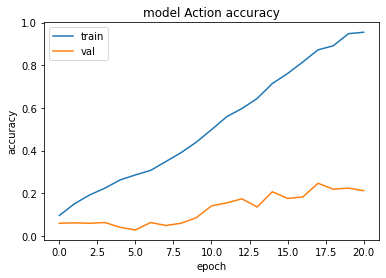

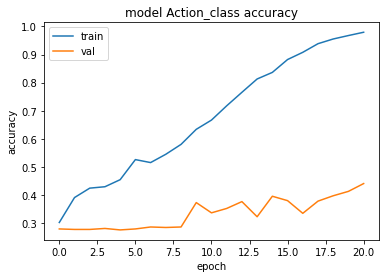

In [ ]:
#As we can see gradual overfitting.
plotter(base_resnet)

###Hyperparameter Tuning


####(Data augmentation) to check if still overfitting ?

In [ ]:

base_resnet= tf.keras.applications.ResNet50(input_shape=input_dim, include_top=False, weights= None)
base_resnet.trainable=True

global_pool1=tf.keras.layers.GlobalAveragePooling2D()(base_resnet.output) #1

dense_output1= tf.keras.layers.Dense(21,name='Action',activation='sigmoid')(global_pool1)
dense_output2= tf.keras.layers.Dense(5,name='Action_class',activation='sigmoid')(global_pool1)

base_resnet=tf.keras.Model(base_resnet.input, outputs=[dense_output1,dense_output2])

base_resnet.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
#Tried Adam optimizer with learning rate then tried SGD with same lr and momentum, we noticed Adam converges faster, and is mostly considered in image classification tasks.

lr= 0.0001 #2
decrease_lr_rate= tf.keras.optimizers.schedules.InverseTimeDecay(lr, decay_steps= 10000, decay_rate=10, staircase=False) 

base_resnet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=decrease_lr_rate), #4
                        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                        metrics ={'Action_class':tf.metrics.CategoricalAccuracy(name='Accuracy'),'Action':tf.metrics.CategoricalAccuracy(name='Accuracy')})


In [ ]:
#Data augmentation
base_resnet_aug =base_resnet.fit(training_generator_aug,epochs=30,verbose=1,validation_data=validation_generator, callbacks=[callback])


Epoch 1/30
56/56 [==============================] - 65s 1s/step - loss: 4.8856 - Action_loss: 3.1707 - Action_class_loss: 1.7149 - Action_Accuracy: 0.0776 - Action_class_Accuracy: 0.2924 - val_loss: 4.7129 - val_Action_loss: 3.0997 - val_Action_class_loss: 1.6132 - val_Action_Accuracy: 0.0590 - val_Action_class_Accuracy: 0.1962
Epoch 2/30
56/56 [==============================] - 58s 1s/step - loss: 4.3593 - Action_loss: 2.8846 - Action_class_loss: 1.4748 - Action_Accuracy: 0.1484 - Action_class_Accuracy: 0.3689 - val_loss: 5.2496 - val_Action_loss: 3.5123 - val_Action_class_loss: 1.7374 - val_Action_Accuracy: 0.0608 - val_Action_class_Accuracy: 0.2031
Epoch 3/30
56/56 [==============================] - 57s 1s/step - loss: 4.1312 - Action_loss: 2.7182 - Action_class_loss: 1.4130 - Action_Accuracy: 0.1663 - Action_class_Accuracy: 0.3867 - val_loss: 6.2301 - val_Action_loss: 4.4635 - val_Action_class_loss: 1.7666 - val_Action_Accuracy: 0.0642 - val_Action_class_Accuracy: 0.3073
Epoch 4/30

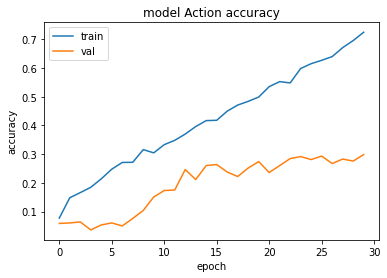

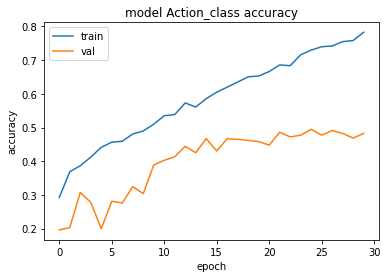

In [ ]:
#As we can see it does reduces the overfitting but the accuracy is still very poor with higher epochs it still overfits. 
plotter(base_resnet_aug)

 #### (Data Augmentation + Dropout)to check if still overfitting ?

In [ ]:
base_resnet_aug_drop= tf.keras.applications.ResNet50(input_shape=input_dim, include_top=False, weights= None)
base_resnet_aug_drop.trainable=True

#Adding seperate GlobalAveragePooling2D layers for both 
#Adding flatten() layer
#Adding dropout=0.3 

global_pool1=tf.keras.layers.GlobalAveragePooling2D()(base_resnet_aug_drop.output) #1
flatten1 =tf.keras.layers.Flatten()(global_pool1)
dropout1= tf.keras.layers.Dropout(0.3)(flatten1)
dense_output1= tf.keras.layers.Dense(21,name='Action',activation='sigmoid')(dropout1)

global_pool2=tf.keras.layers.GlobalAveragePooling2D()(base_resnet_aug_drop.output) #1
flatten2 =tf.keras.layers.Flatten()(global_pool2)
dropout2= tf.keras.layers.Dropout(0.3)(flatten2)
dense_output2= tf.keras.layers.Dense(5,name='Action_class',activation='sigmoid')(dropout2)

base_resnet_aug_drop=tf.keras.Model(base_resnet_aug_drop.input, outputs=[dense_output1,dense_output2])

base_resnet_aug_drop.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
#Tried Adam optimizer with learning rate then tried SGD with same lr and momentum, we noticed Adam converges faster, and is mostly considered in image classification tasks.

lr= 0.0001 #2
decrease_lr_rate= tf.keras.optimizers.schedules.InverseTimeDecay(lr, decay_steps= 10000, decay_rate=10, staircase=False) 

base_resnet_aug_drop.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=decrease_lr_rate), #4
                        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                        metrics ={'Action_class':tf.metrics.CategoricalAccuracy(name='Accuracy'),'Action':tf.metrics.CategoricalAccuracy(name='Accuracy')})


In [ ]:
# (Dropout + Data augmentation)
base_resnet_aug_drop =base_resnet_aug_drop.fit(training_generator_aug,epochs=30,verbose=1,validation_data=validation_generator, callbacks=[callback])


Epoch 1/30
56/56 [==============================] - 88s 1s/step - loss: 5.5062 - Action_loss: 3.5401 - Action_class_loss: 1.9661 - Action_Accuracy: 0.0664 - Action_class_Accuracy: 0.2606 - val_loss: 4.6651 - val_Action_loss: 3.0364 - val_Action_class_loss: 1.6287 - val_Action_Accuracy: 0.0833 - val_Action_class_Accuracy: 0.2760
Epoch 2/30
56/56 [==============================] - 58s 1s/step - loss: 5.1912 - Action_loss: 3.3985 - Action_class_loss: 1.7927 - Action_Accuracy: 0.0843 - Action_class_Accuracy: 0.3142 - val_loss: 5.4139 - val_Action_loss: 3.2873 - val_Action_class_loss: 2.1266 - val_Action_Accuracy: 0.0521 - val_Action_class_Accuracy: 0.2847
Epoch 3/30
56/56 [==============================] - 58s 1s/step - loss: 4.9378 - Action_loss: 3.2065 - Action_class_loss: 1.7313 - Action_Accuracy: 0.1083 - Action_class_Accuracy: 0.3125 - val_loss: 7.3674 - val_Action_loss: 4.2938 - val_Action_class_loss: 3.0736 - val_Action_Accuracy: 0.0608 - val_Action_class_Accuracy: 0.2795
Epoch 4/30

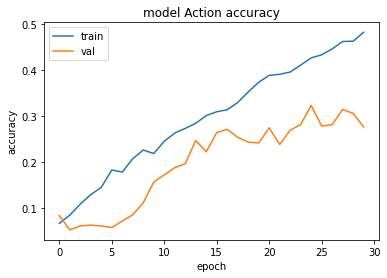

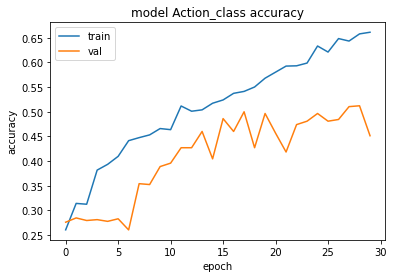

In [ ]:
#As we can see it does reduces the overfitting and generalises well but the accuracy is still very poor with higher epochs also it still overfits.

plotter(base_resnet_aug_drop)

#### (Aug+Dropout+Adding regularisation) with epoch=50

In [ ]:
#Regularisation
#alpha=0.001 model showed underfitting.

alpha=1e-05

base_resnet_aug_drop_reg= tf.keras.applications.ResNet50(input_shape=input_dim, include_top=False, weights= None)
base_resnet_aug_drop_reg.trainable=True

#Adding seperate GlobalAveragePooling2D layers for both 
#Adding flatten() layer
#Adding dropout=0.3 

global_pool1=tf.keras.layers.GlobalAveragePooling2D()(base_resnet_aug_drop_reg.output) #1
flatten1 =tf.keras.layers.Flatten()(global_pool1)
#Dropout
dropout1= tf.keras.layers.Dropout(0.3)(flatten1)
dense_output1= tf.keras.layers.Dense(21,name='Action',activation='sigmoid',kernel_regularizer=keras.regularizers.l2(alpha))(dropout1)

global_pool2=tf.keras.layers.GlobalAveragePooling2D()(base_resnet_aug_drop_reg.output) #1
flatten2 =tf.keras.layers.Flatten()(global_pool2)
#Dropout
dropout2= tf.keras.layers.Dropout(0.3)(flatten2)
dense_output2= tf.keras.layers.Dense(5,name='Action_class',activation='sigmoid',kernel_regularizer=keras.regularizers.l2(alpha))(dropout2)

base_resnet_aug_drop_reg=tf.keras.Model(base_resnet_aug_drop_reg.input, outputs=[dense_output1,dense_output2])

base_resnet_aug_drop_reg.summary()


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
#Tried Adam optimizer with learning rate then tried SGD with same lr and momentum, we noticed Adam converges faster, and is mostly considered in image classification tasks.

lr= 0.0001 #2
decrease_lr_rate= tf.keras.optimizers.schedules.InverseTimeDecay(lr, decay_steps= 10000, decay_rate=10, staircase=False) 

base_resnet_aug_drop_reg.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=decrease_lr_rate), #4
                        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                        metrics ={'Action_class':tf.metrics.CategoricalAccuracy(name='Accuracy'),'Action':tf.metrics.CategoricalAccuracy(name='Accuracy')})


In [ ]:
# (Data augmentation)
base_resnet_aug_drop_reg =base_resnet_aug_drop_reg.fit(training_generator_aug,epochs=50,verbose=1,validation_data=validation_generator, callbacks=[callback])


Epoch 1/50
56/56 [==============================] - 66s 1s/step - loss: 5.5456 - Action_loss: 3.5543 - Action_class_loss: 1.9907 - Action_Accuracy: 0.0703 - Action_class_Accuracy: 0.2617 - val_loss: 4.8370 - val_Action_loss: 3.1252 - val_Action_class_loss: 1.7112 - val_Action_Accuracy: 0.0625 - val_Action_class_Accuracy: 0.2778
Epoch 2/50
56/56 [==============================] - 57s 1s/step - loss: 5.1558 - Action_loss: 3.3351 - Action_class_loss: 1.8202 - Action_Accuracy: 0.0854 - Action_class_Accuracy: 0.3114 - val_loss: 6.1391 - val_Action_loss: 3.6595 - val_Action_class_loss: 2.4791 - val_Action_Accuracy: 0.0608 - val_Action_class_Accuracy: 0.2778
Epoch 3/50
56/56 [==============================] - 57s 1s/step - loss: 4.8649 - Action_loss: 3.1469 - Action_class_loss: 1.7175 - Action_Accuracy: 0.1189 - Action_class_Accuracy: 0.3549 - val_loss: 7.1325 - val_Action_loss: 4.4007 - val_Action_class_loss: 2.7312 - val_Action_Accuracy: 0.0590 - val_Action_class_Accuracy: 0.2760
Epoch 4/50

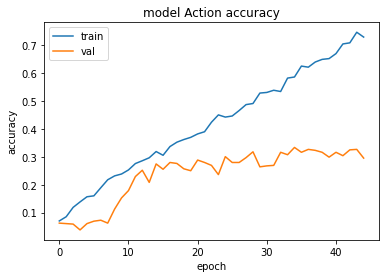

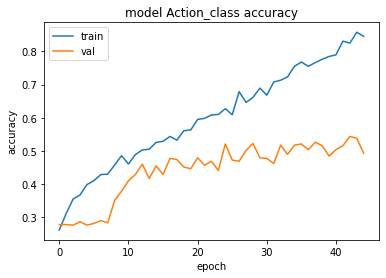

In [ ]:
#As we can see it does reduces the overfitting, but only a little bit and the accuracy is still very poor with higher epochs also.
# we will now move to another approach and use learned weights = imagenet and learning Resnet50 fully.

plotter(base_resnet_aug_drop_reg)

# ResNet50 (No Transfer Learning)
(No Transfer learning with weights= imagenet + trainable=true + Data Augmentation + Optimizer -Adam with decaying lr)

In [ ]:
#Resnet being famous for solving vanishing gradient problems via its skip connection traversing weight during back prop.
#We used the pretrained weights of ImageNet.(pre-training on ImageNet)

resnet_ntransfer= tf.keras.applications.ResNet50(input_shape=input_dim, include_top=False, weights= 'imagenet')
resnet_ntransfer.trainable=True

#Adding seperate GlobalAveragePooling2D layers for both 
#Adding flatten layer + dropout.

global_pool1=tf.keras.layers.GlobalAveragePooling2D()(resnet_ntransfer.output) #1
flatten1 =tf.keras.layers.Flatten()(global_pool1)
dropout1= tf.keras.layers.Dropout(0.3)(flatten1)
dense_output1= tf.keras.layers.Dense(21,name='Action',activation='sigmoid')(dropout1)

global_pool2=tf.keras.layers.GlobalAveragePooling2D()(resnet_ntransfer.output) #1
flatten2 =tf.keras.layers.Flatten()(global_pool2)
dropout2= tf.keras.layers.Dropout(0.3)(flatten2)
dense_output2= tf.keras.layers.Dense(5,name='Action_class',activation='sigmoid')(dropout2)

resnet_ntransfer=tf.keras.Model(resnet_ntransfer.input, outputs=[dense_output1,dense_output2])

resnet_ntransfer.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________

In [ ]:
#Tried Adam optimizer with learning rate then tried SGD with same lr and momentum, we noticed Adam converges faster, and is mostly considered in image classification tasks.

lr= 0.0001 #2
decrease_lr_rate= tf.keras.optimizers.schedules.InverseTimeDecay(lr, decay_steps= 10000, decay_rate=10, staircase=False) 

resnet_ntransfer.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=decrease_lr_rate), #4
                        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                        metrics ={'Action_class':tf.metrics.CategoricalAccuracy(name='Accuracy'),'Action':tf.metrics.CategoricalAccuracy(name='Accuracy')})


In [ ]:

resnet_ntransfer =resnet_ntransfer.fit(training_generator_aug,epochs=50,verbose=1,validation_data=validation_generator, callbacks=[callback])

Epoch 1/50
56/56 [==============================] - 64s 1s/step - loss: 2.8449 - Action_loss: 1.9955 - Action_class_loss: 0.8494 - Action_Accuracy: 0.4297 - Action_class_Accuracy: 0.6814 - val_loss: 5.9179 - val_Action_loss: 3.8656 - val_Action_class_loss: 2.0523 - val_Action_Accuracy: 0.0486 - val_Action_class_Accuracy: 0.2778
Epoch 2/50
56/56 [==============================] - 58s 1s/step - loss: 0.8311 - Action_loss: 0.6123 - Action_class_loss: 0.2188 - Action_Accuracy: 0.8237 - Action_class_Accuracy: 0.9280 - val_loss: 6.4134 - val_Action_loss: 4.0698 - val_Action_class_loss: 2.3436 - val_Action_Accuracy: 0.0417 - val_Action_class_Accuracy: 0.1354
Epoch 3/50
56/56 [==============================] - 57s 1s/step - loss: 0.3776 - Action_loss: 0.2777 - Action_class_loss: 0.0999 - Action_Accuracy: 0.9291 - Action_class_Accuracy: 0.9715 - val_loss: 5.9021 - val_Action_loss: 3.7208 - val_Action_class_loss: 2.1813 - val_Action_Accuracy: 0.0312 - val_Action_class_Accuracy: 0.2830
Epoch 4/50

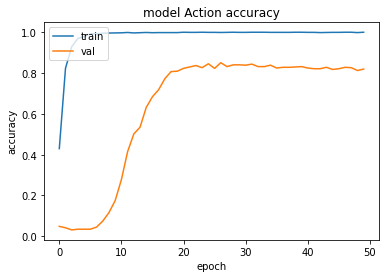

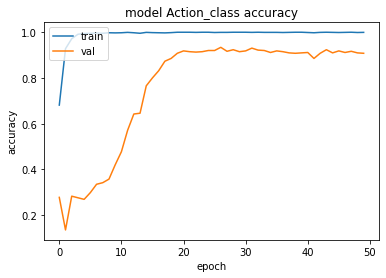

In [ ]:
#Plotting training and validation accuracy curves for both labels- action and action_class.

plotter(resnet_ntransfer)

###Hyperparameter Tuning 


#### (Regularisation) to see if overfitting reduces more?

In [18]:
#Resnet being famous for solving vanishing gradient problems via its skip connection traversing weight during back prop.
#We used the pretrained weights of ImageNet.(pre-training on ImageNet)

#Regularisation
#alpha=0.001 model showed underfitting.
alpha=1e-05

resnet_ntransfer_reg= tf.keras.applications.ResNet50(input_shape=input_dim, include_top=False, weights= 'imagenet')
resnet_ntransfer_reg.trainable=True

#Adding seperate GlobalAveragePooling2D layers for both 
#Adding flatten layer + dropout.

global_pool1=tf.keras.layers.GlobalAveragePooling2D()(resnet_ntransfer_reg.output) #1
flatten1 =tf.keras.layers.Flatten()(global_pool1)
dropout1= tf.keras.layers.Dropout(0.3)(flatten1)
dense_output1= tf.keras.layers.Dense(21,name='Action',activation='sigmoid', kernel_regularizer=keras.regularizers.l2(alpha))(dropout1)

global_pool2=tf.keras.layers.GlobalAveragePooling2D()(resnet_ntransfer_reg.output) #1
flatten2 =tf.keras.layers.Flatten()(global_pool2)
dropout2= tf.keras.layers.Dropout(0.3)(flatten2)
dense_output2= tf.keras.layers.Dense(5,name='Action_class',activation='sigmoid',kernel_regularizer=keras.regularizers.l2(alpha))(dropout2)

resnet_ntransfer_reg=tf.keras.Model(resnet_ntransfer_reg.input, outputs=[dense_output1,dense_output2])



In [19]:
#Tried Adam optimizer with learning rate then tried SGD with same lr and momentum, we noticed Adam converges faster, and is mostly considered in image classification tasks.

lr= 0.0001 #2
decrease_lr_rate= tf.keras.optimizers.schedules.InverseTimeDecay(lr, decay_steps= 10000, decay_rate=10, staircase=False) 

resnet_ntransfer_reg.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=decrease_lr_rate), #4
                        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                        metrics ={'Action_class':tf.metrics.CategoricalAccuracy(name='Accuracy'),'Action':tf.metrics.CategoricalAccuracy(name='Accuracy')})


In [20]:
# NO Transfer learning + Data Augmentation
history =resnet_ntransfer_reg.fit(training_generator_aug,epochs=30,verbose=1,validation_data=validation_generator, callbacks=[callback])

Epoch 1/30
56/56 [==============================] - 291s 5s/step - loss: 2.8696 - Action_loss: 2.0570 - Action_class_loss: 0.8122 - Action_Accuracy: 0.4241 - Action_class_Accuracy: 0.6970 - val_loss: 7.7140 - val_Action_loss: 4.6720 - val_Action_class_loss: 3.0414 - val_Action_Accuracy: 0.0365 - val_Action_class_Accuracy: 0.2760
Epoch 2/30
56/56 [==============================] - 70s 1s/step - loss: 0.8057 - Action_loss: 0.6171 - Action_class_loss: 0.1881 - Action_Accuracy: 0.8253 - Action_class_Accuracy: 0.9314 - val_loss: 5.3309 - val_Action_loss: 3.5844 - val_Action_class_loss: 1.7460 - val_Action_Accuracy: 0.0347 - val_Action_class_Accuracy: 0.2795
Epoch 3/30
56/56 [==============================] - 61s 1s/step - loss: 0.3776 - Action_loss: 0.2867 - Action_class_loss: 0.0904 - Action_Accuracy: 0.9196 - Action_class_Accuracy: 0.9738 - val_loss: 5.3493 - val_Action_loss: 3.5189 - val_Action_class_loss: 1.8299 - val_Action_Accuracy: 0.0330 - val_Action_class_Accuracy: 0.2726
Epoch 4/3

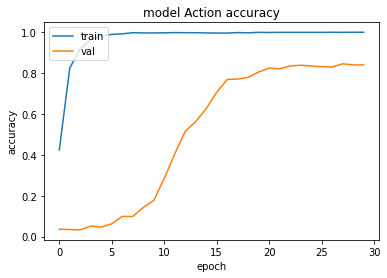

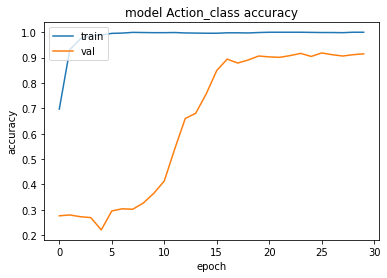

In [22]:
#Plotting training and validation accuracy curves for both labels- action and action_class.
plotter(history)


#Saving Final Model

In [23]:

resnet_ntransfer_reg.save("final_resnet_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



#Evaluating Final Model

In [24]:
#Evaluating the saved model to Test split data.
# we are getting Action_Accuracy: 87.1% and Action_class_Accuracy: 94.09%
resnet_ntransfer_reg.evaluate(testing_generator)

18/18 [==============================] - 106s 6s/step - loss: 0.7058 - Action_loss: 0.4640 - Action_class_loss: 0.2413 - Action_Accuracy: 0.8715 - Action_class_Accuracy: 0.9410


[0.7058407664299011,
 0.4640387296676636,
 0.24127303063869476,
 0.8715277910232544,
 0.9409722089767456]

#Predictions on Final Model 

In [134]:
df_test= pd.read_csv("./drive/MyDrive/S40AR_test_data.csv")
df_test.head()

,FileName
0,Img_1005.jpg
1,Img_1012.jpg
2,Img_1014.jpg
3,Img_1015.jpg
4,Img_102.jpg


In [135]:
size=len(df_test)
image = np.empty((size, *input_dim))


In [136]:
image.shape

(2100, 224, 224, 3)

In [137]:
# model predict on given unseen test data images

for i, temp in enumerate(df_test['FileName']) :
    #Removing the corrupted file Img_3201.jpg
      if temp != 'Img_3201.jpg' :
        filepath = prefix + temp 
        # print(i)
        # print(filepath)
        data = Image.open(filepath)
        data= np.asarray(data)
        data = tf.image.resize_with_pad(data,224,224)
        data = data/225.0 
        image[i,]= data


In [138]:
#Predicting and storing the action and action_class o/p.
action,action_class=resnet_ntransfer_reg.predict(image)

# Convert and Inverse Transform Labels

In [139]:
#conversion form categorical to numerical
action=np.argmax(action, axis=1)
action_class=np.argmax(action_class, axis=1)

#Decoding the label encoded classes 
action= ActionEncoder.inverse_transform(action)
action_class= ActionClassEncoder.inverse_transform(action_class)


In [140]:
#write to the dataframe
#add 2 colums and append a,ac 

df_predicted=pd.DataFrame()
df_predicted['action']=pd.Series(action)
df_predicted['action_class']=pd.Series(action_class)
# df_predicted.head()

# #deleting image= Img_3201.jpg from dataframe df_test
# df_test = df_test[df_test.FileName != 'Img_3201.jpg']
# #Resetting index. drop=true as to not append old index as new column.
# df_test= df_test.reset_index(drop=True)

final_df_predicted = pd.DataFrame()
final_df_predicted= pd.concat([df_test,df_predicted], axis=1, ignore_index=False)
final_df_predicted.head(2100)

,FileName,action,action_class
0,Img_1005.jpg,riding_a_horse,Interacting_with_animal
1,Img_1012.jpg,shooting_an_arrow,other_activity
2,Img_1014.jpg,texting_message,using_comm_device
3,Img_1015.jpg,shooting_an_arrow,other_activity
4,Img_102.jpg,texting_message,using_comm_device
...,...,...,...
2095,Img_985.jpg,riding_a_horse,Interacting_with_animal
2096,Img_986.jpg,jumping,other_activity
2097,Img_993.jpg,jumping,other_activity
2098,Img_994.jpg,using_a_computer,using_comm_device


#write to csv

In [153]:
final_df_predicted.to_csv('/content/drive/MyDrive/predictions.csv')